# Modelo de Regresión Simple

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [1]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

## Descripción Previa de la Base de Datos

Resumen Numérico

In [2]:
pdf4 = bd5.sample(False, 0.1, 0).select('Dest','Horario','ArrDelay','DepDelay','RetrasoNeto').toPandas()
pdf4.corr()

,Horario,ArrDelay,DepDelay,RetrasoNeto
Horario,1.000000,0.135776,0.120853,0.081756
ArrDelay,0.135776,1.000000,0.959762,0.371824
DepDelay,0.120853,0.959762,1.000000,0.096182
RetrasoNeto,0.081756,0.371824,0.096182,1.000000


Resumen Gráfico

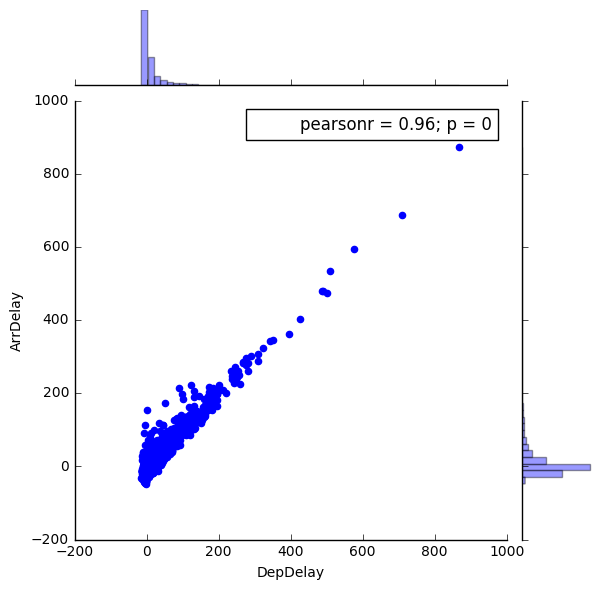

In [3]:
import seaborn as sns
%matplotlib inline
sns.jointplot(x="DepDelay", y="ArrDelay", data=pdf4)

## Configuración de la base de datos

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

assembler = VectorAssembler(
    inputCols=['DepDelay'],
    outputCol='features')

bd6 = assembler.transform(bd5).select(col("ArrDelay").alias("label"),'features')
bd6.show()

+-----+--------+
|label|features|
+-----+--------+
| -7.0|  [-5.0]|
| -3.0|   [5.0]|
| -3.0|  [-3.0]|
| -2.0|  [-7.0]|
| -2.0|  [-6.0]|
|  0.0|  [-1.0]|
| -6.0|   [0.0]|
|  7.0|   [0.0]|
| -9.0|  [-1.0]|
| -2.0|  [-1.0]|
| 13.0|   [1.0]|
|-16.0|  [-2.0]|
|-21.0|  [-4.0]|
|-16.0|  [-1.0]|
|-11.0|   [0.0]|
| -8.0|   [0.0]|
| -4.0|  [13.0]|
|  0.0|  [17.0]|
| -2.0|  [12.0]|
|  2.0|  [19.0]|
+-----+--------+
only showing top 20 rows



### Ajuste del modelo

In [6]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression()
model = lr.fit(bd6)
pred = model.transform(bd6)

/usr/lib/spark/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


Coeficientes

In [7]:
print(model.intercept,model.coefficients)

-4.3994410804913295 [1.02786002478]


Modelo Teórico:

__ArrDelay = $\beta_0$ + $\beta_1$*DepDelay + $\epsilon$__ 


Modelo Predictivo:

__ArrDelay = -4.4 + 1.03*DepDelay__




Valores Predichos y Residuos

In [8]:
pred = pred.withColumn('residual', pred.label-pred.prediction)
pred.show()

+-----+--------+-------------------+-------------------+
|label|features|         prediction|           residual|
+-----+--------+-------------------+-------------------+
| -7.0|  [-5.0]| -9.538741204370066| 2.5387412043700657|
| -3.0|   [5.0]| 0.7398590433874066|-3.7398590433874066|
| -3.0|  [-3.0]| -7.483021154818571|  4.483021154818571|
| -2.0|  [-7.0]| -11.59446125392156|   9.59446125392156|
| -2.0|  [-6.0]|-10.566601229145814|  8.566601229145814|
|  0.0|  [-1.0]| -5.427301105267077|  5.427301105267077|
| -6.0|   [0.0]|-4.3994410804913295|-1.6005589195086705|
|  7.0|   [0.0]|-4.3994410804913295| 11.399441080491329|
| -9.0|  [-1.0]| -5.427301105267077|-3.5726988947329232|
| -2.0|  [-1.0]| -5.427301105267077| 3.4273011052670768|
| 13.0|   [1.0]|-3.3715810557155823|  16.37158105571558|
|-16.0|  [-2.0]| -6.455161130042824| -9.544838869957175|
|-21.0|  [-4.0]| -8.510881179594318|-12.489118820405682|
|-16.0|  [-1.0]| -5.427301105267077|-10.572698894732923|
|-11.0|   [0.0]|-4.399441080491

Representación gráfica de resultados

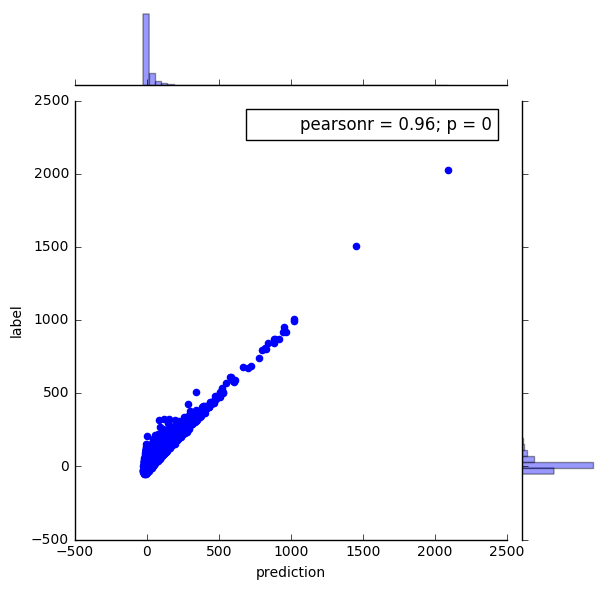

In [11]:
pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="label", data=pdpred)

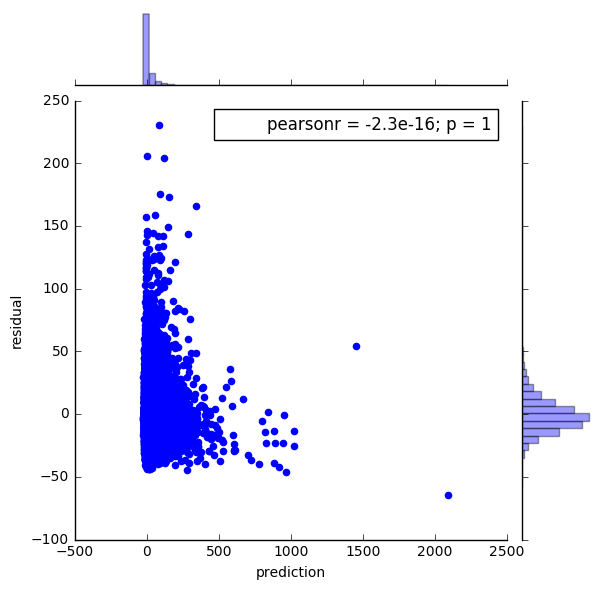

In [12]:
sns.jointplot(x="prediction", y="residual", data=pdpred)

Métricas de Evaluación (R2, RMSE, MAE)

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="rmse").evaluate(pred))
print(RegressionEvaluator(metricName="r2").evaluate(pred))


15.498421344920246
0.9161065747950511


Otros parámetros opcionales del modelo

In [10]:
#lr = LinearRegression()
#lr = LinearRegression(
    #maxIter=5, 
    #regParam=0.0,
    #elasticNetParam=0.0,
    #solver="normal", 
    #weightCol="weight")